In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from itertools import chain

Using TensorFlow backend.


In [2]:
def load_data():
    ann = pd.read_csv('100.csv')
    ann.drop(['Sub', 'Chan', 'Num', 'Aux'], axis = 1, inplace=True)
    sig = pd.read_csv('100.sig.csv')
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    sig[['MLII', 'V5']] = scaler.fit_transform(sig[['MLII', 'V5']])
    return ann, sig

In [3]:
def plot(sample, delta = 392):
    plt.figure(figsize=(14,12))
    sig1 = sig['MLII'][sample - delta:sample + delta]
    sig2 = sig['V5'][sample - delta:sample + delta]
    plt.scatter(sample, np.fmin(sig1.min(), sig2.min()), c='red')
    for j, k in enumerate([3,5,7]):
        plt.subplot(3,1,1 + j)
        s1 = [np.mean(sig1[i:i + k]) for i, _ in enumerate(sig1)]        
        plt.plot(sig1.values)
        plt.plot(s1)

    plt.figure(figsize=(14,12))
    for j, k in enumerate([1,3,5]):
        plt.subplot(3,1,1 + j)
        plt.plot(pd.ewma(sig1, k, adjust=False))
        sig1.plot()

In [4]:
#plot(599, 392)

### Autoencoder

In [242]:
def create_encoding_layers(units = [128, 64, 32]):
    return [Dense(u, activation='relu') for u in units]

def create_decoding_layers(units = [64, 128, 784]):
    return [Dense(u, activation='relu' if i < len(units) -1 else 'sigmoid') for i, u in enumerate(units)]

def create_encoding_conv_pool_layers(kernels = [16, 8, 8], batch_norm = True):    
    conv = [Conv2D(k, (3, 3), activation='relu', padding='same') for k in kernels]
    pool = [MaxPooling2D((2, 2), padding='same') for k in kernels]
    if batch_norm:
        bn = [BatchNormalization() for k in kernels]
        return list(chain(*zip(conv, bn, pool)))
    else:
        return list(chain(*zip(conv, pool)))

def create_decoding_conv_pool_layers(kernels = [8, 8, 16]):
    conv = [Conv2D(k, (3, 3), activation='relu', \
                   padding='same' if i < len(kernels) - 1 else 'valid') for i, k in enumerate(kernels)]    
    pool = [UpSampling2D((2, 2)) for k in kernels]
    last = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    return list(chain(*zip(conv, pool), [last]))

def connect_layers(input, layers):
    for i,l in enumerate(layers):
        if i == 0:
            layer = l(input)
        else:
            layer = l(layer)
    return layer

In [176]:
def create_encoders(input_dim = 784, layers_dim = [128, 64], encoding_dim = 32):    
    normal_input  = Input(shape=(input_dim,), name='normal_input')
    encoded_input = Input(shape=(encoding_dim,), name = 'encoded_input')

    encoding_layers = create_encoding_layers(layers_dim + [encoding_dim])
    layers_dim.reverse()
    decoding_layers = create_decoding_layers(layers_dim + [input_dim])

    encoded = connect_layers(normal_input, encoding_layers)
    decoded = connect_layers(encoded, decoding_layers)
    semi_decoded = connect_layers(encoded_input, decoding_layers)

    autoencoder = Model(normal_input, decoded)
    encoder = Model(normal_input, encoded)
    decoder = Model(encoded_input, semi_decoded)

    return autoencoder, encoder, decoder

In [225]:
def create_conv_encoders(input_dim = (28, 28), kernels = [16, 8, 8], encoding_dim = (4, 4)):
    normal_input = Input(shape=(*input_dim, 1), name='normal_input')  # adapt this if using `channels_first` image data format
    encoded_input = Input(shape=(*encoding_dim, kernels[-1]), name = 'encoded_input')

    encoding_layers = create_encoding_conv_pool_layers(kernels)
    kernels.reverse()
    decoding_layers = create_decoding_conv_pool_layers(kernels)

    encoded = connect_layers(normal_input, encoding_layers)
    decoded = connect_layers(encoded, decoding_layers)
    semi_decoded = connect_layers(encoded_input, decoding_layers)

    encoder = Model(normal_input, encoded)
    decoder = Model(encoded_input, semi_decoded)
    autoencoder = Model(normal_input, decoded)

    return autoencoder, encoder, decoder

In [8]:
ann, sig = load_data()

In [266]:
def get_train_test_set(shape = (784, )):
    x, delta = [], int(784 / 2)
    for i in ann[ann['Type'].isin(['A', 'N'])]['Sample #']:
        if i >= delta and i < len(sig) - delta:
            s = np.array(sig['MLII'][i - delta:i + delta])        
#             s = np.array([np.mean(s[i:i + 5]) for i, _ in enumerate(s)])
            x.append(s.reshape(shape))
    x_train = np.array(x)        
    x_test = np.copy(x_train)
    return x_train, x_test

In [10]:
def plot_diagrams(x_test, x_decoded):
    n, figsize = 10, (20, 3)
    plt.figure(figsize=figsize)
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_decoded[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()    
    plt.figure(figsize=figsize)
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.plot(x_test[i].reshape((784)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.plot(x_decoded[i].reshape((784)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [11]:
def plot_loss_accuracy(loss, x_test, x_decoded):
    plt.figure(figsize=(14,3))
    plt.subplot(1,2,1)
    plt.plot(loss.history['loss'])    
    plt.subplot(1,2,2)
    plt.plot(x_test[0].reshape((784)))
    plt.plot(x_decoded[0].reshape((784)))

In [192]:
def load_weights(model, filename, load_prev):
    if filename is not None and load_prev:
        try:
            model.load_weights(filename)
            print('Succesfully loaded weights')
        except Exception as e:
            print('Can\'t load weights to model', e)

In [239]:
def save_weights(model, filename):
    if filename is not None:
        try:
            model.save_weights(filename)
            #pass
        except Exception as e:
            print('Can\'t save weights to model', e)

In [134]:
def run(encoders, shape, epochs = 10, filename = None, load_prev = True):
    global x_test, x_decoded
    autoencoder, encoder, decoder = encoders
    x_train, x_test = get_train_test_set(shape)    
    
    autoencoder.compile(optimizer='adam', loss = 'mse')
    load_weights(autoencoder, filename, load_prev)
    loss = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=512, shuffle=True, verbose = 1, 
                           validation_data=(x_test, x_test))
    save_weights(autoencoder, filename)     
    
    x_decoded = decoder.predict(encoder.predict(x_test))
    plot_diagrams(x_test, x_decoded)
    plot_loss_accuracy(loss, x_test, x_decoded)

Succesfully loaded weights
Train on 2268 samples, validate on 2268 samples
Epoch 1/50
2268/2268 [==============================] - 1s - loss: 0.0070 - val_loss: 0.0058
Epoch 2/50
2268/2268 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0043
Epoch 3/50
2268/2268 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0032
Epoch 4/50
2268/2268 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0024
Epoch 5/50
2268/2268 [==============================] - 0s - loss: 0.0023 - val_loss: 0.0020
Epoch 6/50
2268/2268 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0018
Epoch 7/50
2268/2268 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0017
Epoch 8/50
2268/2268 [==============================] - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 9/50
2268/2268 [==============================] - 0s - loss: 0.0016 - val_loss: 0.0015
Epoch 10/50
2268/2268 [==============================] - 0s - loss: 0.0015 - val_loss: 0

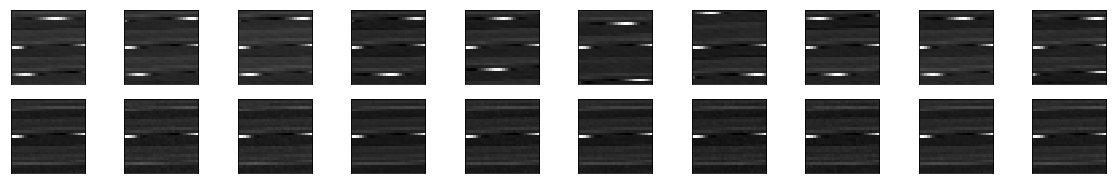

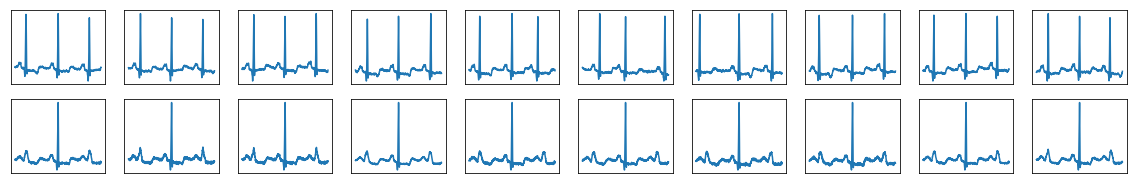

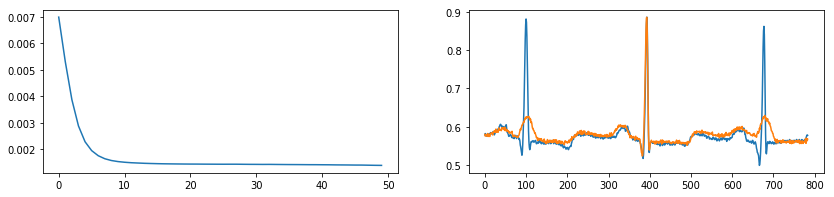

In [278]:
run(create_encoders(784, [], 64), shape=(784,), epochs=50, filename='784_64.h5', load_prev=True)

Succesfully loaded weights
Train on 2268 samples, validate on 2268 samples
Epoch 1/20
2268/2268 [==============================] - 2s - loss: 0.0017 - val_loss: 0.0015
Epoch 2/20
2268/2268 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0015
Epoch 3/20
2268/2268 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0015
Epoch 4/20
2268/2268 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0015
Epoch 5/20
2268/2268 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0015
Epoch 6/20
2268/2268 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0015
Epoch 7/20
2268/2268 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 8/20
2268/2268 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 9/20
2268/2268 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 10/20
2268/2268 [==============================] - 0s - loss: 0.0014 - val_loss: 0

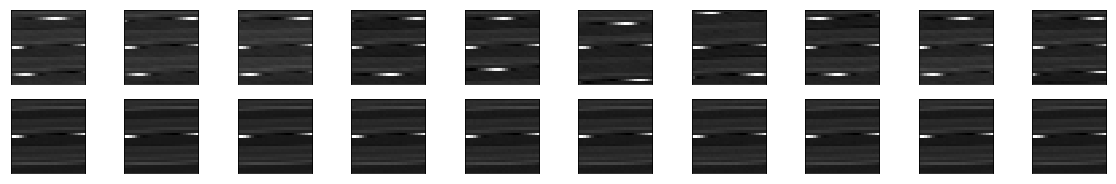

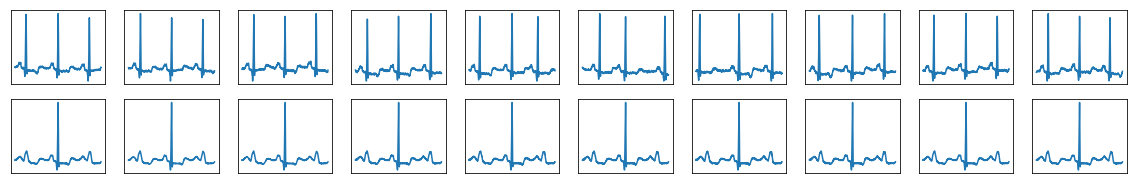

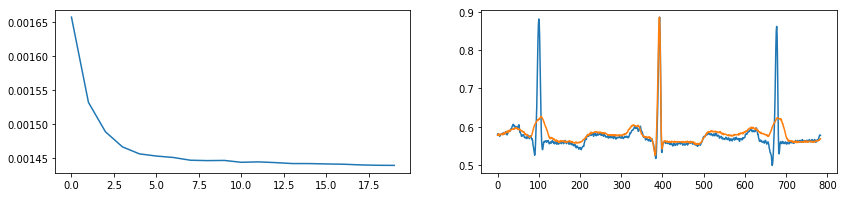

In [277]:
run(create_encoders(784, [256, 128], 64), shape=(784,), epochs=20, filename='784_256_128_64.h5', load_prev=True)

Succesfully loaded weights
Train on 2268 samples, validate on 2268 samples
Epoch 1/5
2268/2268 [==============================] - 2s - loss: 0.0017 - val_loss: 0.0015
Epoch 2/5
2268/2268 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0013
Epoch 3/5
2268/2268 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0012
Epoch 4/5
2268/2268 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 5/5
2268/2268 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0011


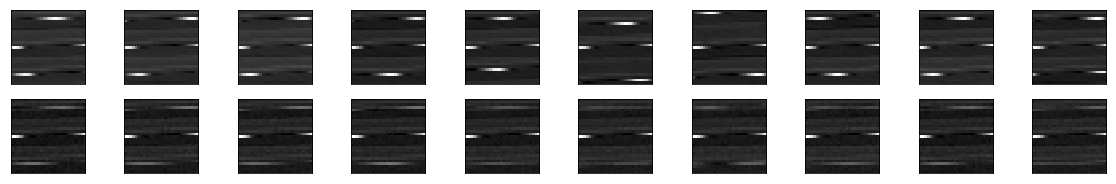

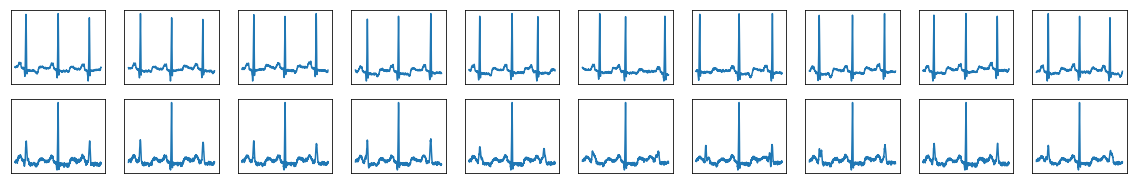

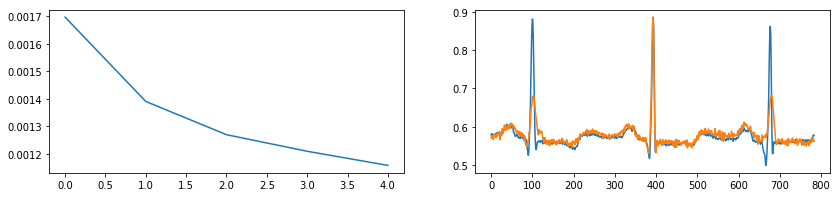

In [273]:
run(create_encoders(784, [512], 64), shape=(784,), epochs=5, filename='784_512_64.h5', load_prev=True)

In [240]:
encoders = create_conv_encoders()

Can't load weights to model Dimension 0 in both shapes must be equal, but are 3 and 8 for 'Assign_3739' (op: 'Assign') with input shapes: [3,3,1,16], [8,1,3,3].
Train on 2235 samples, validate on 2235 samples
Epoch 1/5
2235/2235 [==============================] - 4s - loss: 0.0077 - val_loss: 0.0050
Epoch 2/5
2235/2235 [==============================] - 3s - loss: 0.0037 - val_loss: 0.0038
Epoch 3/5
2235/2235 [==============================] - 3s - loss: 0.0034 - val_loss: 0.0027
Epoch 4/5
2235/2235 [==============================] - 3s - loss: 0.0028 - val_loss: 0.0028
Epoch 5/5
2235/2235 [==============================] - 3s - loss: 0.0027 - val_loss: 0.0026


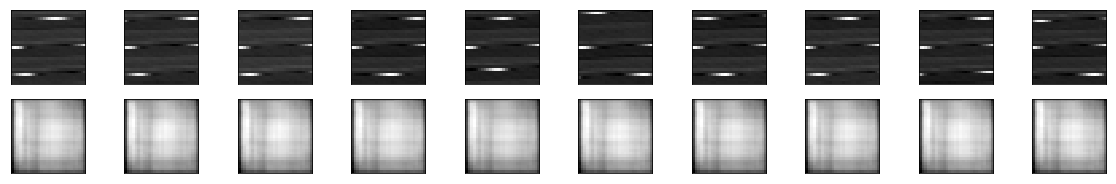

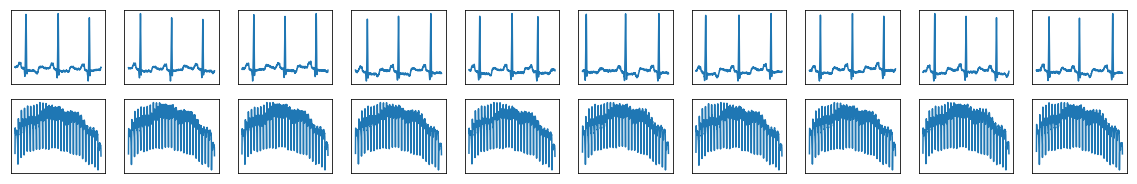

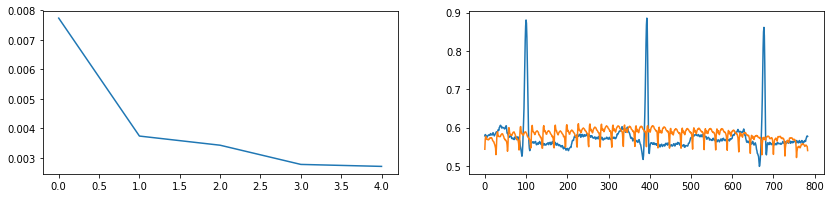

In [241]:
run(encoders, shape=(28,28,1), epochs=250, filename='conv16_8_8.h5', load_prev=True)    

### Batch normalization

In [240]:
encoders = create_conv_encoders()

Can't load weights to model Unable to open file (Unable to open file: name = 'bn_conv16_8_8.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Train on 2268 samples, validate on 2268 samples
Epoch 1/250
2268/2268 [==============================] - 4s - loss: 0.0026 - val_loss: 0.0025
Epoch 2/250
2268/2268 [==============================] - 3s - loss: 0.0025 - val_loss: 0.0024
Epoch 3/250
2268/2268 [==============================] - 3s - loss: 0.0024 - val_loss: 0.0023
Epoch 4/250
2268/2268 [==============================] - 3s - loss: 0.0023 - val_loss: 0.0023
Epoch 5/250
2268/2268 [==============================] - 3s - loss: 0.0023 - val_loss: 0.0023
Epoch 6/250
2268/2268 [==============================] - 3s - loss: 0.0022 - val_loss: 0.0022
Epoch 7/250
2268/2268 [==============================] - 3s - loss: 0.0022 - val_loss: 0.0022
Epoch 8/250
2268/2268 [==============================] - 3s - loss: 0.0022 - val_loss: 0.0022
Epoch 9/250
2268/2268 [

2268/2268 [==============================] - 3s - loss: 8.1566e-04 - val_loss: 8.0896e-04
Epoch 84/250
2268/2268 [==============================] - 3s - loss: 8.0609e-04 - val_loss: 8.2245e-04
Epoch 85/250
2268/2268 [==============================] - 3s - loss: 8.0886e-04 - val_loss: 8.2277e-04
Epoch 86/250
2268/2268 [==============================] - 3s - loss: 8.0815e-04 - val_loss: 7.8467e-04
Epoch 87/250
2268/2268 [==============================] - 3s - loss: 7.8094e-04 - val_loss: 7.7203e-04
Epoch 88/250
2268/2268 [==============================] - 3s - loss: 7.7026e-04 - val_loss: 7.6708e-04
Epoch 89/250
2268/2268 [==============================] - 3s - loss: 7.6171e-04 - val_loss: 7.5691e-04
Epoch 90/250
2268/2268 [==============================] - 3s - loss: 7.5250e-04 - val_loss: 7.4969e-04
Epoch 91/250
2268/2268 [==============================] - 3s - loss: 7.4701e-04 - val_loss: 7.3789e-04
Epoch 92/250
2268/2268 [==============================] - 3s - loss: 7.3530e-04 - val_

2268/2268 [==============================] - 3s - loss: 4.9149e-04 - val_loss: 4.8619e-04
Epoch 163/250
2268/2268 [==============================] - 3s - loss: 4.8760e-04 - val_loss: 4.8283e-04
Epoch 164/250
2268/2268 [==============================] - 3s - loss: 4.8837e-04 - val_loss: 4.8293e-04
Epoch 165/250
2268/2268 [==============================] - 3s - loss: 4.8378e-04 - val_loss: 4.8163e-04
Epoch 166/250
2268/2268 [==============================] - 3s - loss: 4.7923e-04 - val_loss: 4.7745e-04
Epoch 167/250
2268/2268 [==============================] - 3s - loss: 4.7780e-04 - val_loss: 4.7735e-04
Epoch 168/250
2268/2268 [==============================] - 3s - loss: 4.7756e-04 - val_loss: 4.7567e-04
Epoch 169/250
2268/2268 [==============================] - 3s - loss: 4.7432e-04 - val_loss: 4.7246e-04
Epoch 170/250
2268/2268 [==============================] - 3s - loss: 4.7344e-04 - val_loss: 4.7058e-04
Epoch 171/250
2268/2268 [==============================] - 3s - loss: 4.7008e-

2268/2268 [==============================] - 3s - loss: 3.8165e-04 - val_loss: 3.9666e-04
Epoch 241/250
2268/2268 [==============================] - 3s - loss: 4.2589e-04 - val_loss: 3.8711e-04
Epoch 242/250
2268/2268 [==============================] - 3s - loss: 3.8915e-04 - val_loss: 3.7712e-04
Epoch 243/250
2268/2268 [==============================] - 3s - loss: 3.7995e-04 - val_loss: 3.7528e-04
Epoch 244/250
2268/2268 [==============================] - 3s - loss: 3.8000e-04 - val_loss: 3.7488e-04
Epoch 245/250
2268/2268 [==============================] - 3s - loss: 3.8181e-04 - val_loss: 3.7406e-04
Epoch 246/250
2268/2268 [==============================] - 3s - loss: 3.8201e-04 - val_loss: 3.7523e-04
Epoch 247/250
2268/2268 [==============================] - 3s - loss: 3.7886e-04 - val_loss: 3.7209e-04
Epoch 248/250
2268/2268 [==============================] - 3s - loss: 3.8350e-04 - val_loss: 3.7169e-04
Epoch 249/250
2268/2268 [==============================] - 3s - loss: 3.7570e-

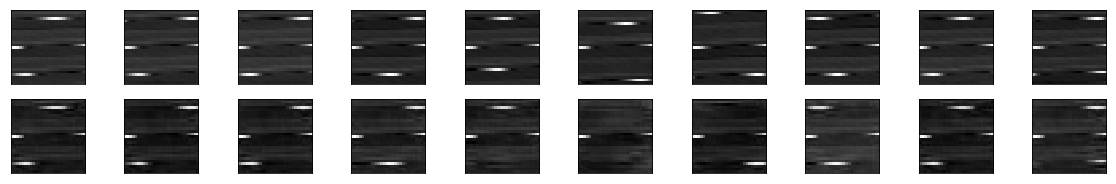

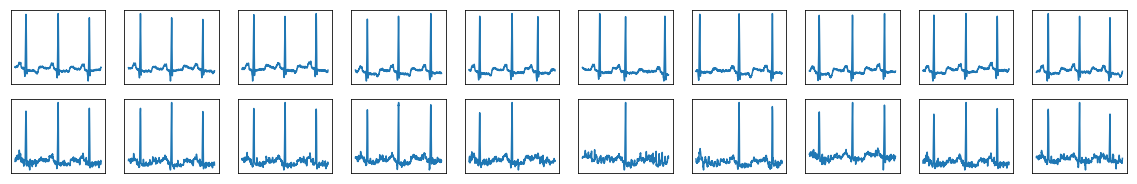

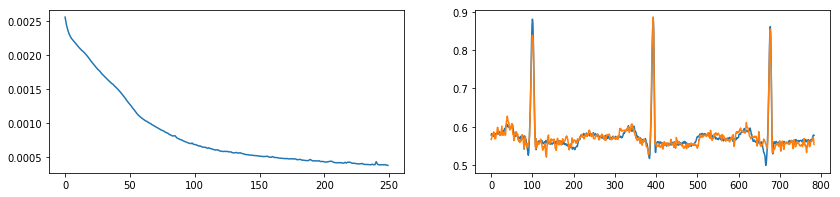

In [269]:
run(encoders, shape=(28,28,1), epochs=250, filename='bn_conv16_8_8.h5', load_prev=True)    

### Smooth data and bn

Can't load weights to model Unable to open file (Unable to open file: name = 'bn_smooth_data.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Train on 2235 samples, validate on 2235 samples
Epoch 1/1000
2235/2235 [==============================] - 1s - loss: 0.0167 - val_loss: 0.0084
Epoch 2/1000
2235/2235 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0082
Epoch 3/1000
2235/2235 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0080
Epoch 4/1000
2235/2235 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0080
Epoch 5/1000
2235/2235 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0079
Epoch 6/1000
2235/2235 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0079
Epoch 7/1000
2235/2235 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0078
Epoch 8/1000
2235/2235 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0078
Epoch 9/1000
2

2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0037
Epoch 85/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 86/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 87/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 88/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0035
Epoch 89/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 90/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 91/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 92/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0032
Epoch 93/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0032
Epoch 94/1000
2235/2235 [=============================

2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 253/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 254/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 255/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 256/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 257/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 258/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 259/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 260/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 261/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 262/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 421/1000
2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 422/1000
2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 423/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 424/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 425/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 426/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 427/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 428/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 429/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 430/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 9.1158e-04 - val_loss: 9.1698e-04
Epoch 581/1000
2235/2235 [==============================] - 0s - loss: 9.1125e-04 - val_loss: 9.1629e-04
Epoch 582/1000
2235/2235 [==============================] - 0s - loss: 9.1033e-04 - val_loss: 9.1134e-04
Epoch 583/1000
2235/2235 [==============================] - 0s - loss: 9.0921e-04 - val_loss: 9.1801e-04
Epoch 584/1000
2235/2235 [==============================] - 0s - loss: 9.0861e-04 - val_loss: 9.1092e-04
Epoch 585/1000
2235/2235 [==============================] - 0s - loss: 9.0807e-04 - val_loss: 9.1028e-04
Epoch 586/1000
2235/2235 [==============================] - 0s - loss: 9.0717e-04 - val_loss: 9.1201e-04
Epoch 587/1000
2235/2235 [==============================] - 0s - loss: 9.0602e-04 - val_loss: 9.1479e-04
Epoch 588/1000
2235/2235 [==============================] - 0s - loss: 9.0521e-04 - val_loss: 9.1107e-04
Epoch 589/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 8.0933e-04 - val_loss: 8.1062e-04
Epoch 737/1000
2235/2235 [==============================] - 0s - loss: 8.0885e-04 - val_loss: 8.1080e-04
Epoch 738/1000
2235/2235 [==============================] - 0s - loss: 8.0818e-04 - val_loss: 8.1295e-04
Epoch 739/1000
2235/2235 [==============================] - 0s - loss: 8.0765e-04 - val_loss: 8.0920e-04
Epoch 740/1000
2235/2235 [==============================] - 0s - loss: 8.0735e-04 - val_loss: 8.0786e-04
Epoch 741/1000
2235/2235 [==============================] - 0s - loss: 8.0657e-04 - val_loss: 8.0956e-04
Epoch 742/1000
2235/2235 [==============================] - 0s - loss: 8.0615e-04 - val_loss: 8.0733e-04
Epoch 743/1000
2235/2235 [==============================] - 0s - loss: 8.0540e-04 - val_loss: 8.1024e-04
Epoch 744/1000
2235/2235 [==============================] - 0s - loss: 8.0509e-04 - val_loss: 8.0603e-04
Epoch 745/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 7.3131e-04 - val_loss: 7.3064e-04
Epoch 893/1000
2235/2235 [==============================] - 0s - loss: 7.3046e-04 - val_loss: 7.3061e-04
Epoch 894/1000
2235/2235 [==============================] - 0s - loss: 7.2993e-04 - val_loss: 7.2975e-04
Epoch 895/1000
2235/2235 [==============================] - 0s - loss: 7.2927e-04 - val_loss: 7.3114e-04
Epoch 896/1000
2235/2235 [==============================] - 0s - loss: 7.2912e-04 - val_loss: 7.3010e-04
Epoch 897/1000
2235/2235 [==============================] - 0s - loss: 7.2835e-04 - val_loss: 7.2863e-04
Epoch 898/1000
2235/2235 [==============================] - 0s - loss: 7.2820e-04 - val_loss: 7.2792e-04
Epoch 899/1000
2235/2235 [==============================] - 0s - loss: 7.2780e-04 - val_loss: 7.2789e-04
Epoch 900/1000
2235/2235 [==============================] - 0s - loss: 7.2720e-04 - val_loss: 7.2774e-04
Epoch 901/1000
2235/2235 [==============================] - 0s - loss:

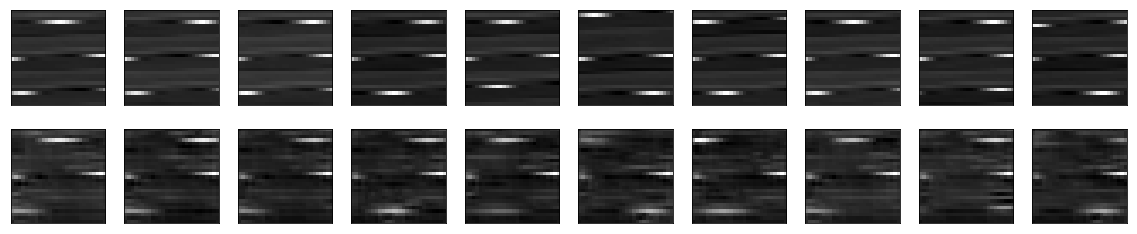

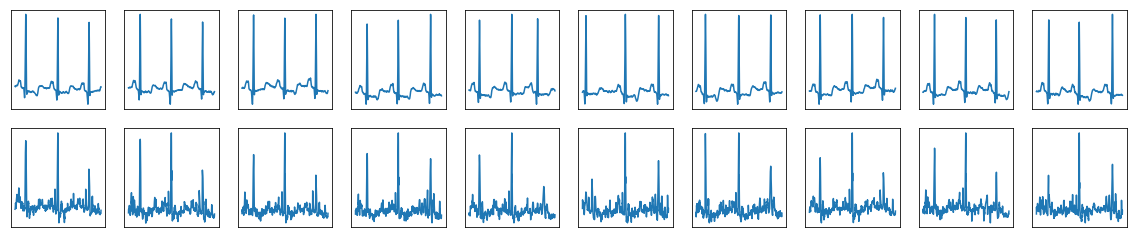

CPU times: user 10min 59s, sys: 1min 43s, total: 12min 43s
Wall time: 13min 32s


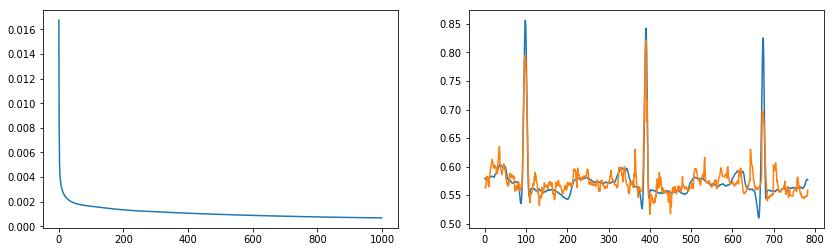

In [64]:
%time run(*create_conv_encoders(), shape=(28,28,1), weights_filename = 'bn_smooth_data.h5', epochs=1000)